# Курсовая работа по предмету "Машинное обучение и анализ данных"
Вариант 10: Условие: `TOER = 0 ` \
Выполнил Кафтаранов Тимур, ШАД-211

### 1. Загрузка необходимых инструментов

In [1]:
# Установка необходимых библиотек
!pip install -U optuna
!pip install catboost
!pip install h2o

# Базовые библиотеки
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка данных
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, mutual_info_classif, mutual_info_regression
from sklearn.utils.multiclass import type_of_target

# Разделение и валидация
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold

# Метрики
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score
)

# Модели
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

# AutoML
import h2o
from h2o.automl import H2OAutoML

# Optuna
import optuna

# Интерпретация моделей
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.4 MB/s eta 0:00:00


### 2. Загрузка данных. Фильтрация по условию

In [2]:
df = pd.read_csv('Dataset_2_DATA.csv')
df = df[df['TOER']==0].reset_index(drop=True)
print(f"Размер датасета после фильтрации: {df.shape}")

# Удаление пустых столбцов или столбцов с константами
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
df.drop(columns=const_cols, inplace=True)
print("Удалены столбцы:", const_cols)

# Проверка пропусков, замена пустых строк и пробелов на NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
missing = df.isna().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print('Столбцы с пропусками: ')
    print(missing)
    print(f'Всего строчек с пропусками: {len(df[df.isnull().any(axis=1)])}')
else:
    print('Пропусков нет')

# Удаление пропущенных строчек
df.dropna(inplace=True)

Размер датасета после фильтрации: (6953, 56)
Удалены столбцы: ['HH_VALID', 'P_VALID', 'WEGGEWEEST', 'TOER', 'TOER_TYPE']
Столбцы с пропусками: 
KREISDUUR        81
PARKEERKOSTEN    21
dtype: int64
Всего строчек с пропусками: 102


Таким образом, в данных не осталось столбцов с пропусками и столбцов с константами: такие столбцы препятствуют качественному обучению модели.

### 3. EDA
Разведывательный анализ данных. Целями этого раздела являются понимание данных и поиск закономерностей.

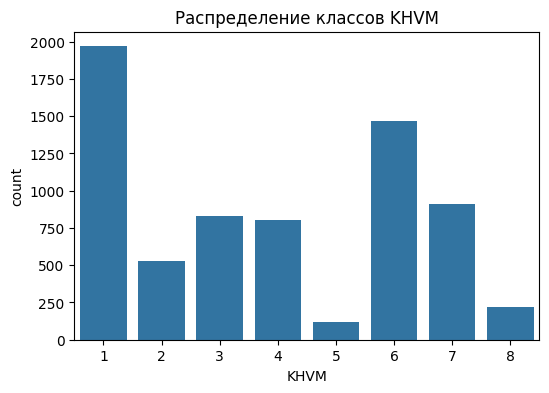

In [3]:
# Расределение классов
plt.figure(figsize=(6,4))
sns.countplot(x='KHVM', data=df)
plt.title('Распределение классов KHVM')
plt.show()

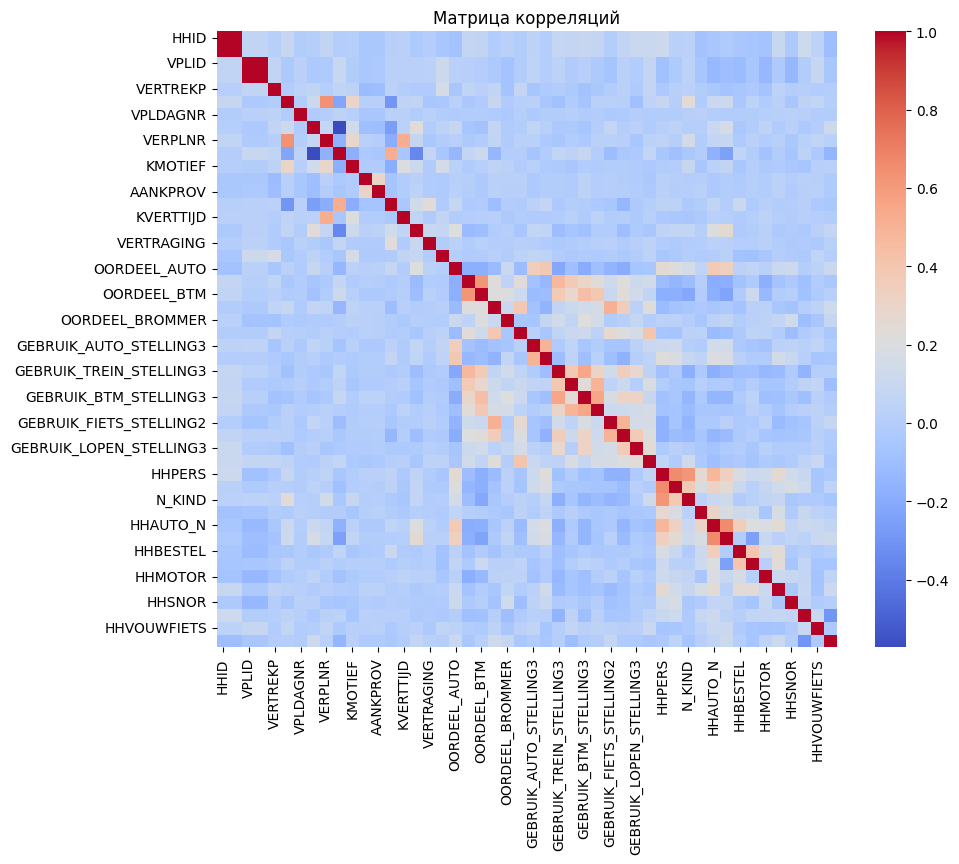

In [4]:
# Матрица корреляций

num_cols = df.select_dtypes(include=[np.number]).columns.drop('KHVM')
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


Выводы по графикам:
1. Классы KHVM распределены сильно неравномерно, поэтому скорее всего модель будет переобучена, нужно исправить этот дисбаланс классов
2. Из датасета необходимо удалить столбцы с идентификаторами, сильно коррелирующие признаки (VERTPROV и AANKPROV почти полностью дублируют друг друга, поэтому AANKPROV будет удален)


### 4. Отбор признаков
Поскольу моделируемая величина категориальна, для отбор признаков можно использовать Хи-квадрат тест.

Датасет богат признаками, поэтому можно использовать уровень значимости в 5%.

In [5]:
def chi2_test(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    """
    Возвращает chi^2-статистику и p-значение для каждого признака.

    Chi2 требует неотрицательных значений, поэтому
    весь X масштабируем в [0, 1] через MinMaxScaler.
    """
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.values)          # numpy-матрица
    chi_vals, p_vals = chi2(X_scaled, y)
    return (pd.DataFrame({"feature": X.columns,
                          "chi2": chi_vals,
                          "p_value": p_vals})
            .sort_values("chi2", ascending=False)
            .reset_index(drop=True))

In [6]:
X = df.drop(columns="KHVM")
y = df["KHVM"]

chi2_df = chi2_test(X, y)

chi2_df[chi2_df['p_value'] < 0.05]

,feature,chi2,p_value
0,ROLAUTO,3111.120792,0.000000e+00
1,AANTRIT,1694.296342,0.000000e+00
2,KAFSTV,857.284517,8.020994e-181
3,KREISDUUR,650.038860,4.049441e-136
4,HHSNOR,618.118424,3.050236e-129
5,HHBESTEL,281.964876,4.277166e-57
6,HHBROM,250.076356,2.668946e-50
7,HHAUTO,217.657460,2.072834e-43
8,HHEBIKE,210.333999,7.413489e-42
9,VERPL,155.260637,3.185020e-30


In [7]:
# Отобранные признаки:
columns = chi2_df[chi2_df['p_value'] < 0.05]['feature'].copy()

# Признак ROLAUTO - отвечает на вопрос, использовал ли гражданин
# автомобиль в данной поездке. Поскольку мы на практике об этом не знаем,
# (иначе зачем мы моделируем сейчас) нам следует отказаться от этого признака.
# Так же удалим из этого набора разнооразные ID
to_remove = ['VPLID', 'HHID', 'ROLAUTO', 'PERSID', 'RitID', 'AANKPROV']
columns = columns[~columns.isin(to_remove)].reset_index().drop('index', axis=1)
columns

,feature
0,AANTRIT
1,KAFSTV
2,KREISDUUR
3,HHSNOR
4,HHBESTEL
5,HHBROM
6,HHAUTO
7,HHEBIKE
8,VERPL
9,HHMOTOR


Оставим только отобранные признаки в данных

In [8]:
columns = columns['feature'].tolist()
X = X[columns]
X.head()

,AANTRIT,KAFSTV,KREISDUUR,HHSNOR,HHBESTEL,HHBROM,HHAUTO,HHEBIKE,VERPL,HHMOTOR,...,HHSAM,HHHYBRID,GEBRUIK_TREIN_STELLING3,GEBRUIK_BTM_STELLING3,GEBRUIK_FIETS_STELLING3,HHFIETS,GEBRUIK_FIETS_STELLING2,HHVOUWFIETS,OORDEEL_BTM,OORDEEL_BROMMER
0,1,13,11,0,0,0,1,1,3,1,...,3,0,3,3,3,1,4,0,3,4
1,1,13,8,0,0,0,1,1,3,1,...,3,0,3,3,3,1,4,0,3,4
2,1,8,7,0,0,0,1,1,3,1,...,3,0,3,3,3,1,4,0,3,4
3,1,8,5,0,0,0,1,1,3,1,...,3,0,3,3,3,1,4,0,3,4
4,3,13,11,0,1,0,1,1,3,1,...,2,0,1,1,2,1,4,0,2,1


Есть две основные стратегии борьбы с дисбалансом классов:
1. OverSampling: Дублировать примеры с недостающим классом
2. UnderSampling: Удалить примеры с избыточным классом

Остановимся на первом варианте, т. к. данных не очень много.

In [9]:
cat_features = ['HHSNOR', 'HHBESTEL', 'HHBROM', 'HHAUTO', 'HHEBIKE', 'VERPL',
                'HHMOTOR', 'DAGSOORT', 'KMOTIEF', 'OORDEEL_AUTO', 'HHSAM',
                'HHHYBRID', 'HHFIETS', 'HHVOUWFIETS']
X[cat_features] = X[cat_features].astype('int')

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)

ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

### 5. Выбор модели, метрики качества, подбор гиперпараметров

Выбранная мною модель - `CatBoostClassifier`, т. к. она хорошо работает с категориальными признаками, которых в датасете много.

В качестве метрики качество будет использован f1-score:

$${{ \mathrm{f1-score} = 2 * \frac{Precision * Recall}{Precision + Recall} }}$$

В свою очередь:
$${{
    \mathrm{Precision} = \dfrac{TP}{TP + FP} \\
    \mathrm{Recall} = \dfrac{TP}{TP + FN}
}}$$

`f1-score` устойчива к дисбалансу классов, что позволит не балансировать классы для тестирования и валидации модели.

In [ ]:
# Подготовка данных - CatBoost может принимать их формате Pool,
# что дает большую производительность
train_pool  = Pool(X_train, y_train, cat_features=cat_features)
valid_pool  = Pool(X_val, y_val, cat_features=cat_features)

def objective(trial):
    params = {
        "loss_function":      "MultiClass",
        "eval_metric":        "TotalF1",
        # ── гиперпараметры, которые можно трогать ─────────────────────────────
        "iterations":         trial.suggest_int("iterations", 200, 2000, step=100),
        "learning_rate":      trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth":              trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg":        trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "random_strength":    trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature":trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count":       trial.suggest_int("border_count", 32, 255),
        "grow_policy":        trial.suggest_categorical(
                                 "grow_policy",
                                 ["SymmetricTree", "Depthwise", "Lossguide"]
                             ),
        # ── фиксированные настройки ───────────────────────────────────────────
        "task_type":          "GPU",
        "devices":            "0",          # какая карта; "0,1" для нескольких
        "random_seed":        42,
        "verbose":            False,
    }

    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=100,
        use_best_model=True,
    )

    return model.get_best_score()["validation"]["TotalF1"]

# --- 3. Запуск Optuna --------------------------------------------------------
study = optuna.create_study(direction="maximize", study_name="catboost_gpu")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Лучший TotalF1: {study.best_value:.5f}")
print("Лучшие параметры:")
for k, v in study.best_params.items():
    print(f"  {k:<18}: {v}")

[I 2025-05-29 18:51:43,213] A new study created in memory with name: catboost_gpu


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-29 18:53:00,905] Trial 0 finished with value: 0.8912543388898835 and parameters: {'iterations': 1600, 'learning_rate': 0.09325823379321814, 'depth': 10, 'l2_leaf_reg': 8.945890719933713, 'random_strength': 0.0007379455867273708, 'bagging_temperature': 0.30713373362651697, 'border_count': 85, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8912543388898835.
[I 2025-05-29 18:53:08,274] Trial 1 finished with value: 0.8516028828706963 and parameters: {'iterations': 400, 'learning_rate': 0.08288678922082678, 'depth': 7, 'l2_leaf_reg': 2.379974456450034, 'random_strength': 9.785669627868108e-08, 'bagging_temperature': 0.9800790053486574, 'border_count': 111, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.8912543388898835.
[I 2025-05-29 18:53:23,883] Trial 2 finished with value: 0.7282430696942859 and parameters: {'iterations': 400, 'learning_rate': 0.0026219436324132353, 'depth': 10, 'l2_leaf_reg': 1.9215588408449014, 'random_strength': 1.222968985628682

### 6. Итоговая точность

In [ ]:
# Получение лучших параметров из Optuna
best_params = study.best_params

# Обязательно дополняем их неизменяемыми
best_params.update({
    "loss_function": "MultiClass",   # или "Logloss" для бинарки
    "eval_metric":   "TotalF1",      # или "F1"
    "task_type":     "GPU",
    "devices":       "0",
    "random_seed":   42,
    "verbose":       False
})

# Обучение модели
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool)

final_model_cat = CatBoostClassifier(**best_params)

# Сохранение модели в файл
final_model.save_model("catboost_final.cbm")

In [10]:
final_model = CatBoostClassifier()
final_model.load_model('catboost_final.cbm')

pred = final_model.predict(X_test)

In [11]:
f1_score(y_test, pred, average='micro')

0.9029905178701677

CatBoost показал хорошее значение ключевой метрики = 0.9.

### 7. AutoML

In [14]:
# Подготовка данных
X_train_val = pd.concat((X_train, X_val))
y_train_val = pd.concat((y_train, y_val))

automl_pool = pd.concat((X_train_val, y_train_val), axis=1)

h2o.init(max_mem_size='2G', nthreads=-1)
h2o_df = h2o.H2OFrame(automl_pool)
h2o_df['KHVM'] = h2o_df['KHVM'].asfactor()
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8], seed=42)
features = [c for c in h2o_df.columns if c != 'KHVM']

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_e5zyali
  JVM stdout: /tmp/tmp_e5zyali/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_e5zyali/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_unknownUser_znbite
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# Обучение automl
learning_time = 300
aml = H2OAutoML(max_runtime_secs=learning_time, seed=42)
aml.train(x=features, y='KHVM', training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/3
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


### 8. Лучшая модель AutoML

In [16]:
leader = aml.leader

path = h2o.save_model(model=leader, path="best_model", force=True)

pred = leader.predict(h2o.H2OFrame(X_test))
pred = pred.as_data_frame()['predict'].tolist()
f1_score(y_test, pred, average='micro')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


0.8307804522246536

In [17]:
print(aml.leaderboard)

model_id                                                   mean_per_class_error    logloss      rmse        mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20250605_115531               0.0816892   0.264929  0.279179  0.0779409
XGBoost_1_AutoML_1_20250605_115531                                    0.0857533   0.308112  0.300912  0.0905478
GBM_1_AutoML_1_20250605_115531                                        0.138718    0.477664  0.393135  0.154555
GLM_1_AutoML_1_20250605_115531                                        0.336103    0.963184  0.587674  0.34536
[4 rows x 5 columns]



Модель AutoML показала худшее значение f1: \
0.9 у CatBoost против 0.83 у AutoML

### 9. Важность признаков

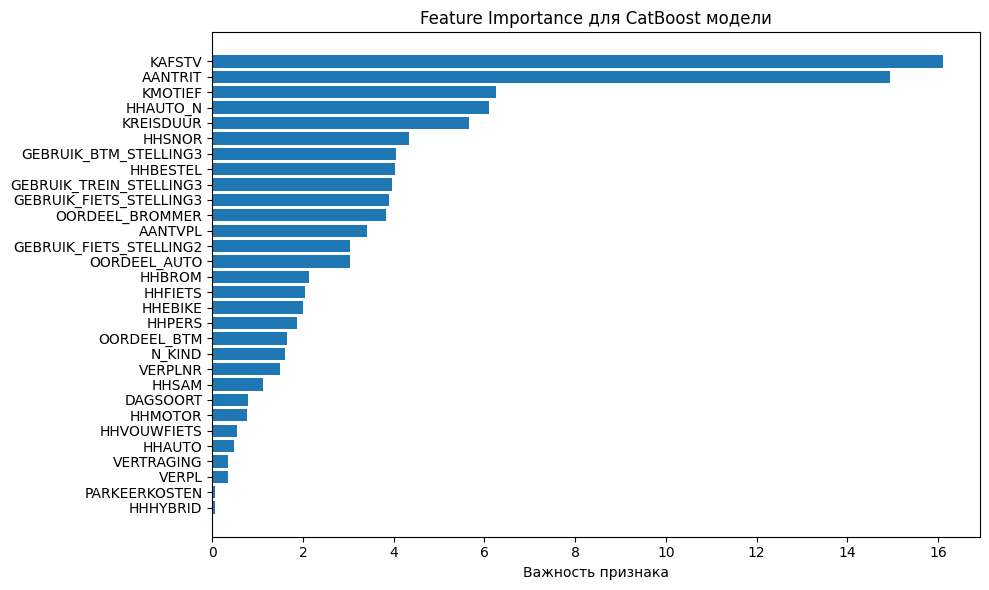

In [12]:
# 1. Получаем массив важностей и список имён признаков
importances = final_model.get_feature_importance()
feature_names = final_model.feature_names_

# 2. Собираем в DataFrame и сортируем по убыванию важности
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# 3. Строим горизонтальную столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()           # переворачиваем, чтобы самый важный был сверху
plt.xlabel('Важность признака')
plt.title('Feature Importance для CatBoost модели')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Первый базовый H2O-модель: XGBoost_1_AutoML_1_20250605_115531


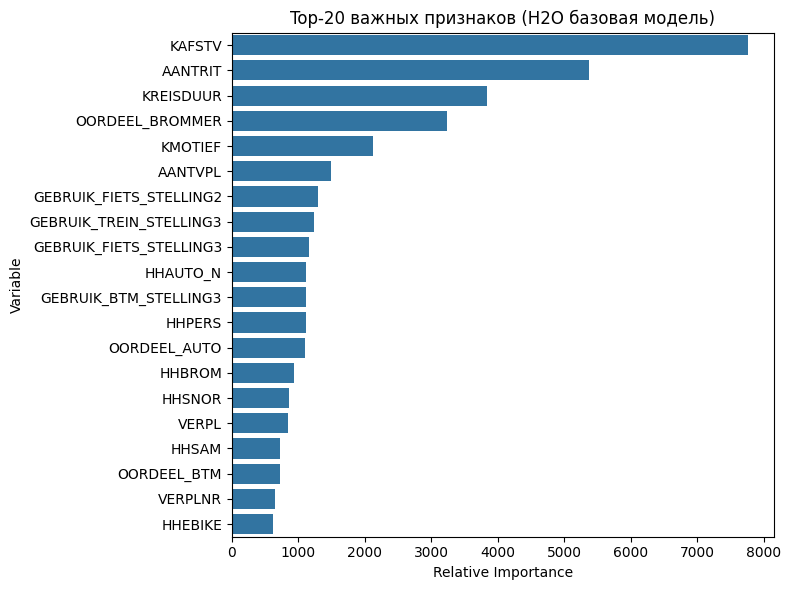

In [18]:
lb = aml.leaderboard.as_data_frame()

base_model_id = lb[~lb['model_id'].str.startswith('StackedEnsemble')].iloc[0]['model_id']
print("Первый базовый H2O-модель:", base_model_id)

base_model = h2o.get_model(base_model_id)

varimp = base_model.varimp(use_pandas=True)
varimp_top20 = varimp.head(20)
plt.figure(figsize=(8,6))
sns.barplot(
    x='relative_importance',
    y='variable',
    data=varimp_top20,
    orient='h'
)
plt.title('Top-20 важных признаков (H2O базовая модель)')
plt.xlabel('Relative Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


Значения топ-20 признаков, влияющих на модель AutoML

В таблице видно, что accuracy у AutoML 99%, а у RF 96%, но эту таблицу трудно читать и понимать, поэтому более наглядное представление сравнения показателей моделей дальше

In [23]:
proba_test = final_model.predict_proba(X_test)[:, 1]  # вероятность класса «1»
idx_max = np.argsort(proba_test)[-2:]  # два самых больших
idx_min = np.argsort(proba_test)[:1]   # один самый маленький

interesting_idxs = [idx_max[0], idx_max[1], idx_min[0]]
print(f"Выбранные индексы из X_test: {interesting_idxs}")

Выбранные индексы из X_test: [np.int64(430), np.int64(634), np.int64(988)]


In [24]:
# Извлекаем сами наблюдения (DataFrame из трёх строк)
X_selected = X_test.iloc[interesting_idxs, :]

# ------------------------------------------------------------------------------
# 3. Создание SHAP-эксплейнера для CatBoost (деревянная модель)
# ------------------------------------------------------------------------------
# Для CatBoostClassifier используем TreeExplainer.
if isinstance(final_model, CatBoostClassifier):
    explainer = shap.TreeExplainer(final_model)
else:
    # Если модель не CatBoost, но всё равно дерево-подобная
    explainer = shap.TreeExplainer(final_model)

# ------------------------------------------------------------------------------
# 4. Вычисление SHAP-значений для выбранных наблюдений
# ------------------------------------------------------------------------------
shap_values = explainer.shap_values(X_selected)

# Для CatBoostClassifier shap_values вернёт список из двух массивов для каждого класса.
# Берём shap_values[1] — вклад в класс "1".
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

In [26]:
shap_vals_pos

array([[[ 2.78994173e+00,  2.51781237e+00, -1.65893294e+00,
         -1.97651113e+00,  6.52624180e-01,  1.26348291e+00,
          1.23385037e+00,  1.59410066e-01],
        [ 4.45154625e-02,  6.37845279e-01,  1.11631305e+00,
         -1.34732692e+00, -2.15784831e+00, -3.91967266e+00,
         -4.98438120e+00, -4.91410190e-01],
        [ 1.03590315e-01,  4.57362541e-01,  1.30185163e+00,
          1.39526727e+00,  8.40548020e-01,  4.04190008e-01,
          1.04423732e+00,  6.15553542e-01],
        [ 4.09025753e-02,  6.22392808e-02, -2.62514217e-01,
         -2.80314490e-01, -4.01189835e-01, -6.78945775e-02,
         -1.97676408e-01,  1.62382804e-02],
        [ 1.50680051e-01,  1.18765710e-01, -1.09775508e-02,
          3.54659369e-02,  3.93204738e-02,  1.08672346e-01,
          3.37900322e-02,  3.80157998e-03],
        [-1.21906483e-03, -5.33106521e-02, -2.46990921e-01,
         -2.86538849e-01, -5.48446636e-01, -1.29229576e-01,
         -2.36317177e-01, -7.05252513e-04],
        [-1.4854

In [21]:


# shap_vals_pos имеет форму (3, n_features)

# ------------------------------------------------------------------------------
# 5. Визуализация: bar plots и waterfall plots для каждого наблюдения
# ------------------------------------------------------------------------------
# 5.1 Bar plot: топ-значимые признаки по абсолютному вкладу
for i, idx in enumerate(interesting_idxs):
    one_d = shap_vals_pos[i].ravel()
    df_shap = pd.DataFrame({
        'feature': feature_names,
        'shap_value': one_d
    })
    df_shap['abs_shap'] = np.abs(df_shap['shap_value'])
    df_shap_sorted = df_shap.sort_values(by='abs_shap', ascending=False).reset_index(drop=True)
    top_n = 10
    df_top = df_shap_sorted.head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(df_top['feature'][::-1], df_top['shap_value'][::-1], color='skyblue')
    plt.axvline(x=0, color='k', linewidth=0.5)
    plt.title(f"Наблюдение {idx} (Bar plot). Топ-{top_n} признаков по abs SHAP")
    plt.xlabel("SHAP value (вклад в вероятность класса 1)")
    plt.tight_layout()
    plt.show()

# 5.2 Waterfall plot: детальный вклад в предсказание
for i, idx in enumerate(interesting_idxs):
    print(f"\n--- Waterfall plot для наблюдения {idx} ---")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_pos[i],
            base_values=explainer.expected_value[1]
                if isinstance(explainer.expected_value, np.ndarray)
                else explainer.expected_value,
            data=X_selected.iloc[i].values,
            feature_names=feature_names
        ),
        max_display=10
    )

# ------------------------------------------------------------------------------
# 6. Интерпретация результатов
# ------------------------------------------------------------------------------
# В bar plot можно увидеть top-10 признаков с указанием знака и величины вклада.
# В waterfall plot показано, как от базового значения (expected_value) по признакам
# складывается итоговая вероятность для каждого наблюдения.
# Для отчёта необходимо выписать:
#   - Топ-3–5 признаков по абсолютному SHAP-значению для каждого idx.
#   - Знак SHAP-значения (положительный/отрицательный вклад) и его величину.
#   - Как базовое значение (средняя вероятность) трансформируется в итоговую.

# Конец примера.


Выбранные индексы из X_test: [np.int64(430), np.int64(634), np.int64(988)]


ValueError: All arrays must be of the same length